$\xi$被设定为8(可以认为像素变化小于8的时候，人类肉眼无法识别)。  
但是我们在数据切片操作的的时候，会把图像的像素数据（取值0-255）标准化为张量（0-1），同时进行均值标差标准化。所以在攻击过程中，$\xi = \frac{8}{255*std}$。

In [1]:
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 8
# 数据集的三通道均值
cifar_10_mean = (0.491, 0.482, 0.447)
# 数据集的三通道标准差
cifar_10_std = (0.202, 0.199, 0.201)
mean = torch.tensor(cifar_10_mean).to(device).view(3, 1, 1)
std = torch.tensor(cifar_10_std).to(device).view(3, 1, 1)
epsilon = 8/255/std  # 将修改上限值标准化
alpha = 0.8/255/std  # 每次修改的值
root = './Data'


In [2]:
# 制作数据集
import os
import glob
import shutil
import numpy as np
from PIL import Image
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_10_mean, cifar_10_std)
])


class AdvDataset(Dataset):
    def __init__(self, data_dir, transform):
        self.images = []
        self.labels = []
        self.names = []
        '''
        data_dir
        ├── class_dir
        │   ├── class1.png
        │   ├── ...
        │   ├── class20.png
        '''
        for i, class_dir in enumerate(sorted(glob.glob(f'{data_dir}/*'))):
            images = sorted(glob.glob(f'{class_dir}/*'))
            self.images += images
            self.labels += ([i] * len(images))
            self.names += [os.path.relpath(imgs, data_dir) for imgs in images]
        self.transform = transform

    def __getitem__(self, idx):
        image = self.transform(Image.open(self.images[idx]))
        label = self.labels[idx]
        return image, label

    def __getname__(self):
        return self.names

    def __len__(self):
        return len(self.images)


adv_set = AdvDataset(root, transform=transform)
adv_names = adv_set.__getname__()
adv_loader = DataLoader(adv_set, batch_size=batch_size, shuffle=False)

print(f'number of images = {adv_set.__len__()}')


number of images = 200


In [3]:
"""在开始攻击前看模型原本的效果"""
def epoch_benign(model, loader, loss_fn):
    model.eval()
    train_acc, train_loss = 0.0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        yp = model(x)
        loss = loss_fn(yp, y)
        train_acc += (yp.argmax(dim=1) == y).sum().item()
        train_loss += loss.item() * x.shape[0]
    return train_acc / len(loader.dataset), train_loss / len(loader.dataset)


In [4]:
"""攻击函数"""


def fgsm(model, x, y, loss_fn, epsilon=epsilon):
    x_adv = x.detach().clone()  # 把x的数据detach到gpu上去
    x_adv.requires_grad = True  # need to obtain gradient of x_adv, thus set required grad
    loss = loss_fn(model(x_adv), y)  # 计算损失值
    loss.backward()  # calculate gradient
    # fgsm: use gradient ascent on x_adv to maximize loss
    x_adv = x_adv + epsilon * x_adv.grad.detach().sign()  # 生成新的攻击图像
    return x_adv


In [5]:
# 开展攻击并生成对抗攻击样本
def gen_adv_examples(model, loader, attack, loss_fn):
    model.eval()
    adv_names = []
    train_acc, train_loss = 0.0, 0.0
    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        x_adv = attack(model, x, y, loss_fn)  # obtain adversarial examples
        yp = model(x_adv)
        loss = loss_fn(yp, y)
        train_acc += (yp.argmax(dim=1) == y).sum().item()
        train_loss += loss.item() * x.shape[0]
        # store adversarial examples
        adv_ex = ((x_adv) * std + mean).clamp(0, 1)  # to 0-1 scale
        adv_ex = (adv_ex * 255).clamp(0, 255)  # 0-255 scale
        adv_ex = adv_ex.detach().cpu().data.numpy().round()  # round to remove decimal part
        # transpose (bs, C, H, W) back to (bs, H, W, C)
        adv_ex = adv_ex.transpose((0, 2, 3, 1))
        adv_examples = adv_ex if i == 0 else np.r_[adv_examples, adv_ex]
    return adv_examples, train_acc / len(loader.dataset), train_loss / len(loader.dataset)

# create directory which stores adversarial examples


def create_dir(data_dir, adv_dir, adv_examples, adv_names):
    if os.path.exists(adv_dir) is not True:
        _ = shutil.copytree(data_dir, adv_dir)
    for example, name in zip(adv_examples, adv_names):
        # image pixel value should be unsigned int
        im = Image.fromarray(example.astype(np.uint8))
        im.save(os.path.join(adv_dir, name))


In [6]:
from pytorchcv.model_provider import get_model as ptcv_get_model

model = ptcv_get_model('resnet110_cifar10', pretrained=True).to(device)
loss_fn = nn.CrossEntropyLoss()

benign_acc, benign_loss = epoch_benign(model, adv_loader, loss_fn)
print(f'benign_acc = {benign_acc:.5f}, benign_loss = {benign_loss:.5f}')


benign_acc = 0.95000, benign_loss = 0.22683


In [7]:
adv_examples, fgsm_acc, fgsm_loss = gen_adv_examples(
    model, adv_loader, fgsm, loss_fn)
print(f'fgsm_acc = {fgsm_acc:.5f}, fgsm_loss = {fgsm_loss:.5f}')

create_dir(root, 'fgsm', adv_examples, adv_names)


fgsm_acc = 0.60000, fgsm_loss = 2.49475


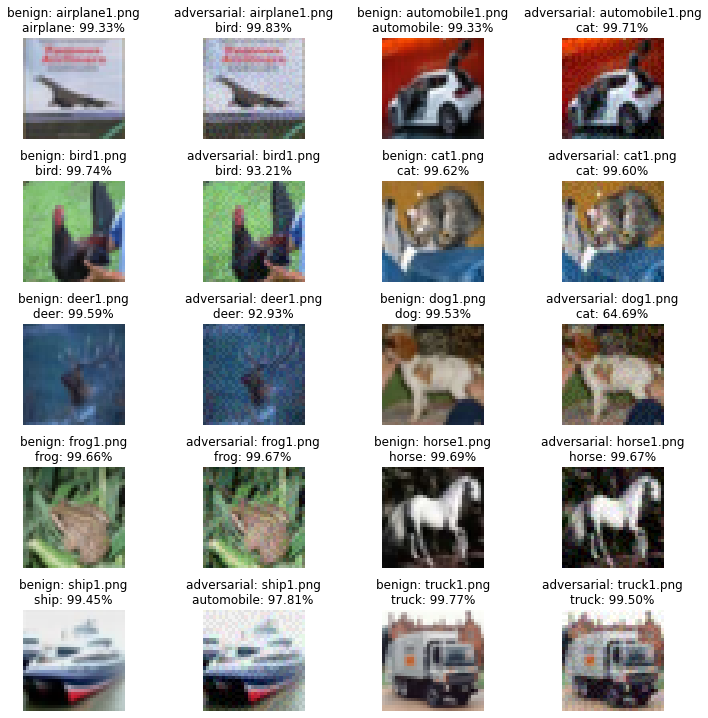

In [8]:
import matplotlib.pyplot as plt

classes = ['airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 20))
cnt = 0
for i, cls_name in enumerate(classes):
    path = f'{cls_name}/{cls_name}1.png'
    # benign image
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(f'./data/{path}')
    logit = model(transform(im).unsqueeze(0).to(device))[0]
    predict = logit.argmax(-1).item()
    prob = logit.softmax(-1)[predict].item()
    plt.title(f'benign: {cls_name}1.png\n{classes[predict]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))
    # adversarial image
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(f'./fgsm/{path}')
    logit = model(transform(im).unsqueeze(0).to(device))[0]
    predict = logit.argmax(-1).item()
    prob = logit.softmax(-1)[predict].item()
    plt.title(f'adversarial: {cls_name}1.png\n{classes[predict]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))
plt.tight_layout()
plt.show()
